## Introduction
This notebook provides an idea of how we can leverage Azure AI services to build PoCs. The goal is to provide an understanding on how a Data Scientist/ Cloud Solution Architect can solve a real-world problem into an artificial intelligence solution.

## Use case
Knowledge bases in enterprises are very common in the industry today and can have extensive number of documents in different categories. Retrieving relevant content based on a user query is a challenging task. This notebook walks through on how leverage Azure OpenAI models to create embeddings from the documents, store in Azure Redis for Cache (Enterprise version), and leverage vector similarity search to extract text based on query.

## Step-by-step process flow

1. All files are uploaded to Storage account bucket 'nlppapers'
2. For each file, call Form Recognizer to get text contents. (We can use other OCR tools. Form recognizer gives you the flexibility to extract text from complex document templates)
3. \[optional\] Store contents of each files at .txt in 'nlppapers_text' container
4. \[optional\] For each file in 'nlppapers_text', call OpenAI.embeddings after chunking
5. Store these embeddings in Azure Enterprise Redis Cache
6. Use Vector Similarity Search feature of Redis Cache
7. Extract top k similar embeddings based on the query
8. Prompt engineer to set-up QnA based on passage (passage being top k similar results extracted from Redis for Cache)

## Installing relevant modules

In [1]:
!pip install redis
!pip install --upgrade openai

Requirement already up-to-date: openai in /anaconda/envs/azureml_py38/lib/python3.8/site-packages (0.26.5)


# Configure connection parameters

In [15]:
OPENAI_API_KEY = "" # SET YOUR OWN API KEY HERE
AZURE_OPENAI_RESOURCE_ENDPOINT = "" # SET A LINK TO YOUR RESOURCE ENDPOINT

REDIS_HOST = ''
REDIS_PORT = 10000
REDIS_PASSWORD = ''

FORM_RECOGNIZER_ENDPOINT = ""
FORM_RECOGNIZER_KEY = ""

# Enter connection string to connect with Blob storage (in your blob storage, find the access keys tab and retreive your connection string)
STORAGE_ACCOUNT_CONNECTION_STRING = ""

## Setting up Azure Cache For Redis

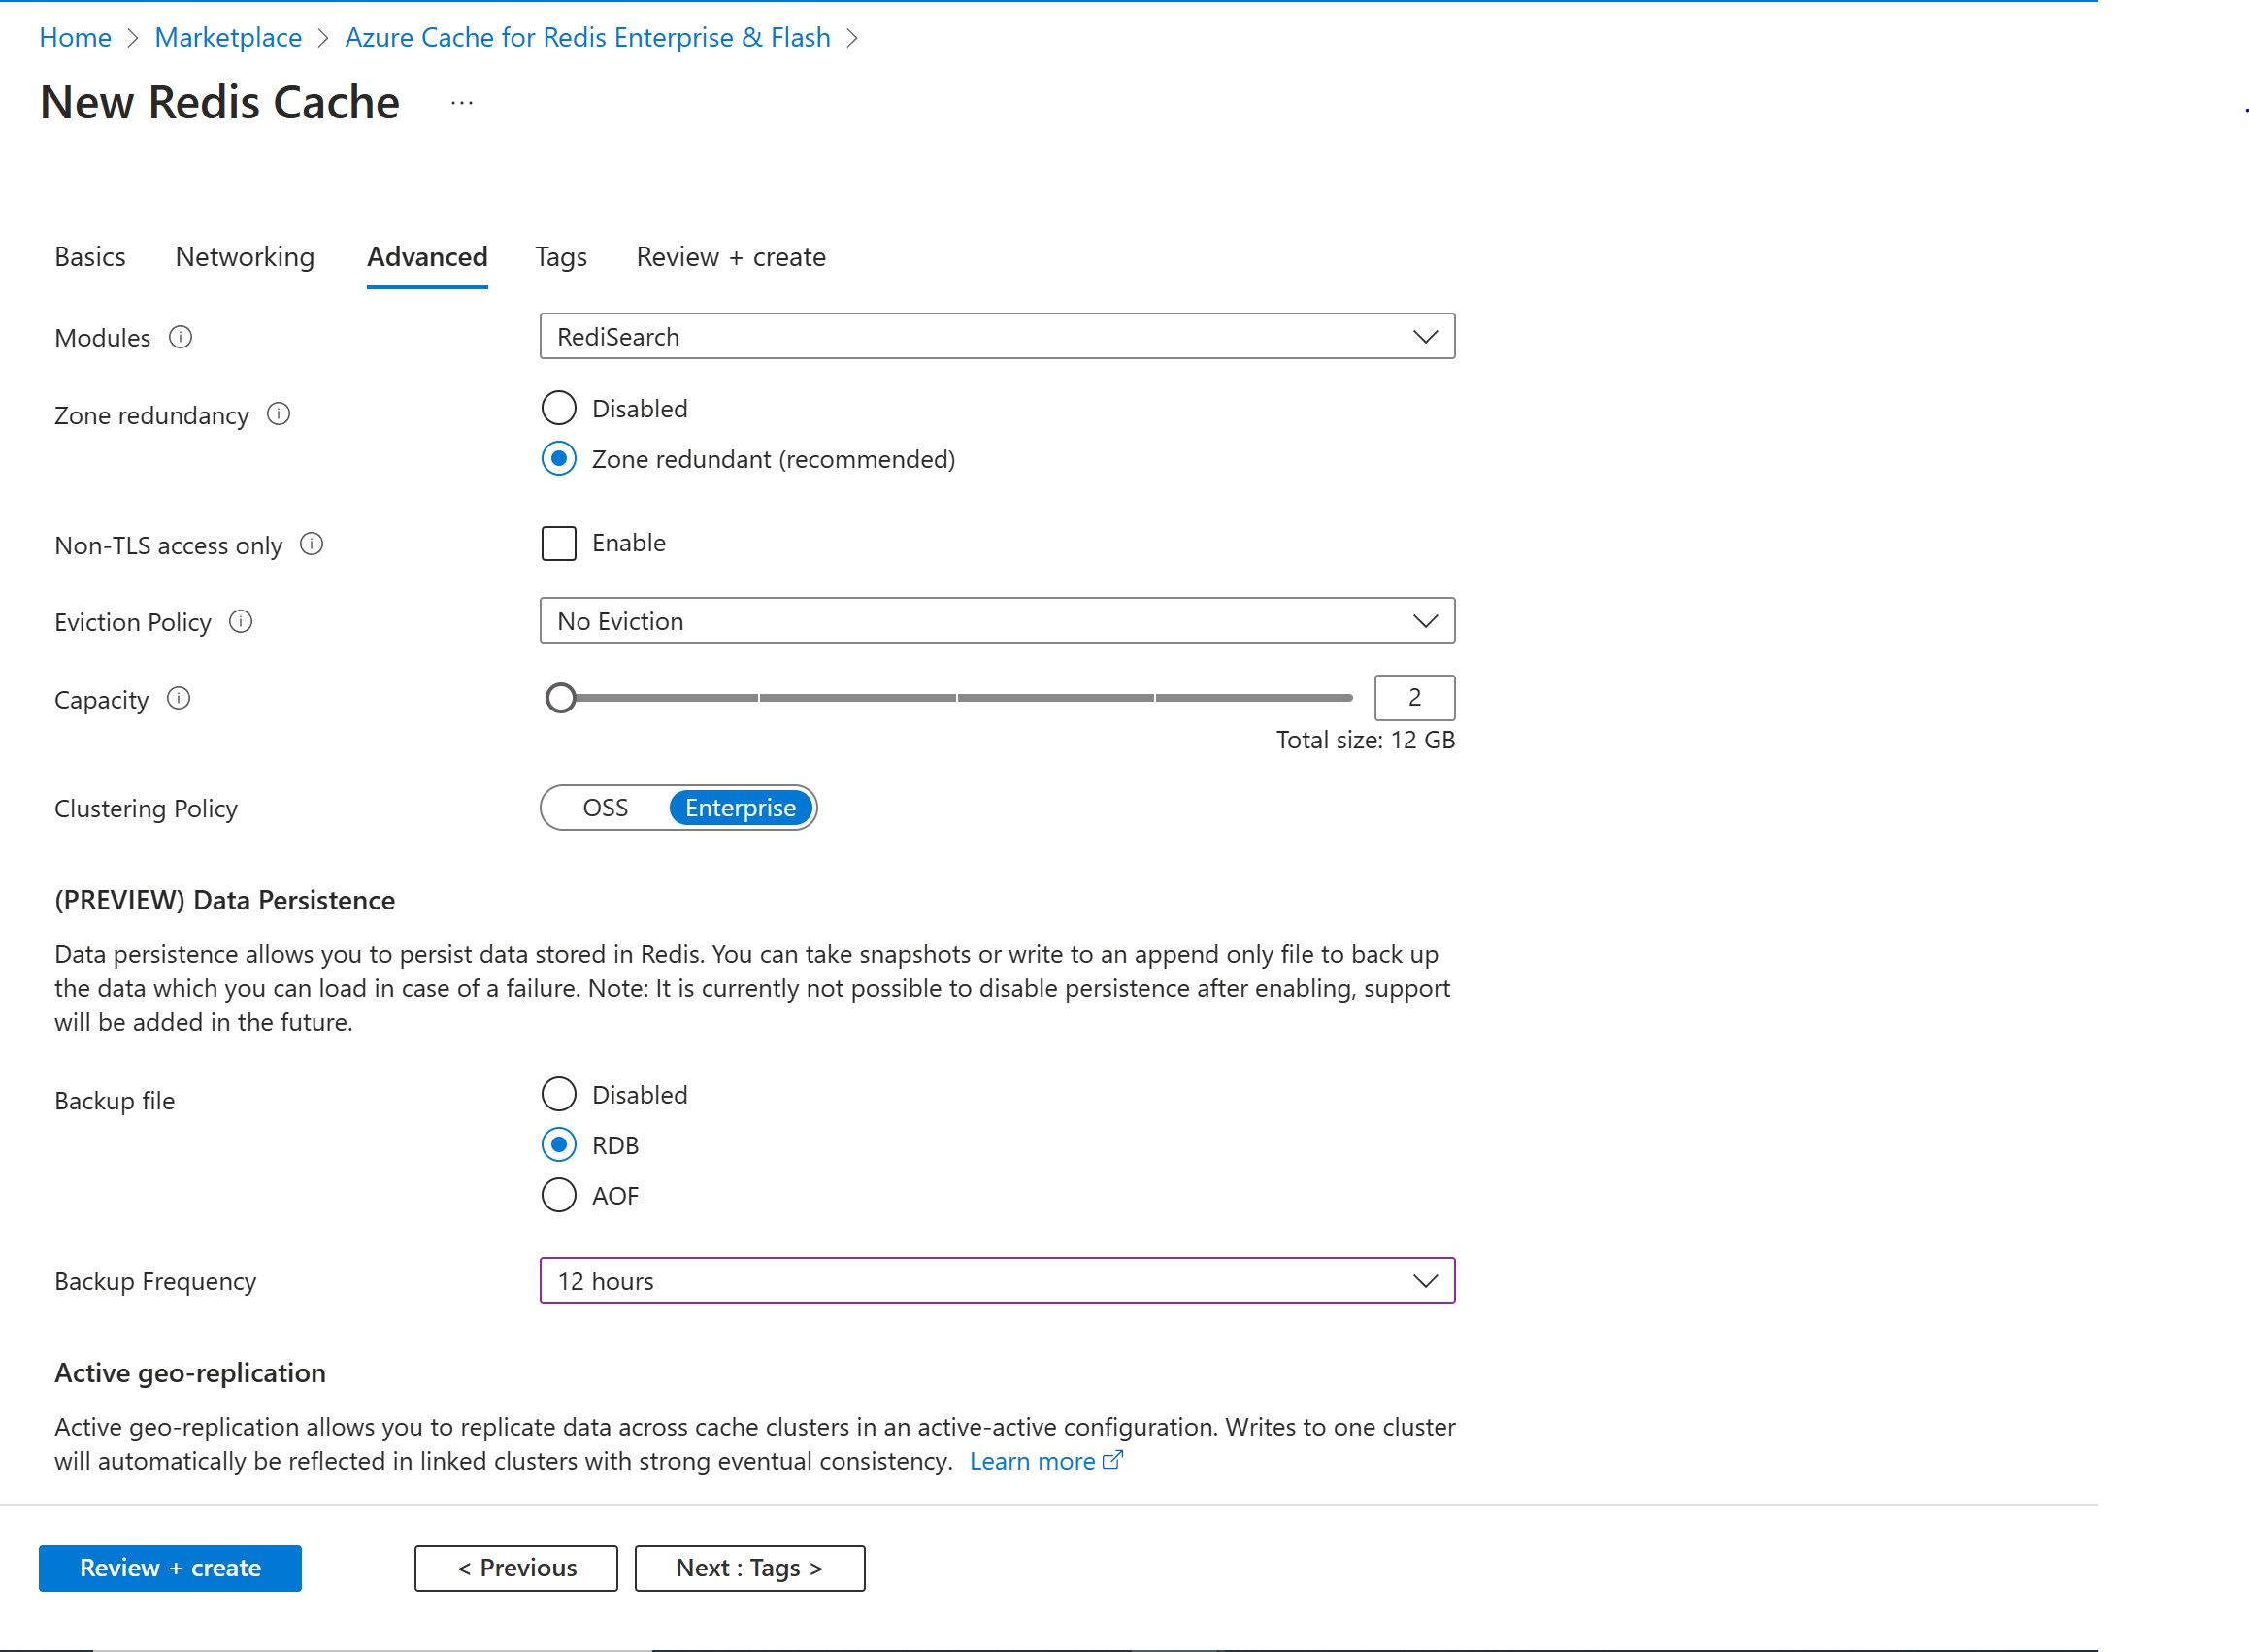

In [14]:
from IPython.display import Image
Image("AzureCacheforRedis.PNG")

## Setting up Form recognizer

In [3]:
""" This code sample shows Prebuilt Read operations with the Azure Form Recognizer client library. 
We can use other OCR tools. Form recognizer provides flexibility to extract text from complex document templates."""

#import form recognizer modules
from azure.core.credentials import AzureKeyCredential
from azure.ai.formrecognizer import DocumentAnalysisClient

container_name_documents = 'nlppapers' #raw pdf files
container_name_processed = 'nlppapers_text' #text files stored in this container

## Process document urls
This function creates tuple of document name and authenticated URLs for documents in the given container.

In [16]:
from azure.storage.blob import BlobServiceClient, BlobClient, ContainerClient, BlobSasPermissions, generate_blob_sas
import datetime

def get_authenticated_urls(container_name):
    """Returns a list of tuple of (document name, authenticated URLs) for
    documents in the given container."""

    urls = []
    # Connect to the storage account
    blob_service_client = BlobServiceClient.from_connection_string(STORAGE_ACCOUNT_CONNECTION_STRING)
    container_client = blob_service_client.get_container_client(container_name)

    # Iterate over the blobs in the container
    blob_list = container_client.list_blobs()
    for blob in blob_list:
        # Retrieve the URL of the blob
        blob_client = container_client.get_blob_client(blob.name)
        blob_url = blob_client.url

        print(f"Generating authenticated URL for: {blob.name}")

        blob_sas = generate_blob_sas(
            account_name=container_client.account_name,
            account_key=container_client.credential.account_key,
            container_name=container_name,
            blob_name=blob.name,
            permission=BlobSasPermissions(read=True),
            expiry=datetime.datetime.utcnow() + datetime.timedelta(hours=1))

        authenticated_url = f"{blob_url}?{blob_sas}"
        urls.append((blob.name, authenticated_url))
    return urls


Bad pipe message: %s [b"\xcb\x836\x84cZ/tt\x10\xc2\xa6\xc8\xdd\xbc\xe3;}\x00\x00\x86\xc00\xc0,\xc0(\xc0$\xc0\x14\xc0\n\x00\xa5\x00\xa3\x00\xa1\x00\x9f\x00k\x00j\x00i\x00h\x009\x008\x007\x006\xc02\xc0.\xc0*\xc0&\xc0\x0f\xc0\x05\x00\x9d\x00=\x005\xc0/\xc0+\xc0'\xc0#\xc0\x13\xc0\t\x00", b'\xa2\x00\xa0\x00\x9e\x00g\x00@\x00?\x00>\x003\x002\x001\x000\xc01\xc0-\xc0)\xc0%\xc0\x0e\xc0\x04\x00\x9c\x00<\x00/\x00\x9a\x00\x99\x00\x98\x00\x97\x00\x96\x00\x07\xc0\x11\xc0\x07\xc0\x0c\xc0\x02\x00\x05\x00\x04\x00\xff\x02\x01\x00\x00g\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x1c\x00\x1a\x00\x17\x00\x19\x00\x1c\x00\x1b\x00\x18\x00\x1a\x00\x16\x00\x0e\x00\r\x00\x0b\x00\x0c\x00\t\x00\n\x00#\x00\x00\x00\r\x00 \x00\x1e\x06\x01\x06\x02\x06\x03\x05\x01\x05\x02\x05\x03\x04\x01\x04\x02\x04\x03\x03\x01\x03\x02\x03\x03\x02']
Bad pipe message: %s [b'']
Bad pipe message: %s [b'\x03']
Bad pipe message: %s [b'\xed\xb6}U\xe7-\xbe -c+Sm\xe0\xfd;\xfa\x8d\x00\x00\xf4\xc00\xc0,\

## Extract text using Form Recognizer
This function extracts text using form recognizer 

In [55]:
def get_content(document_url):
    """Returns the text content of the file at the given URL."""
    print("Analyzing", document_url)

    document_analysis_client = DocumentAnalysisClient(
        endpoint=FORM_RECOGNIZER_ENDPOINT,
        credential=AzureKeyCredential(FORM_RECOGNIZER_KEY),
    )
    
    poller = document_analysis_client.begin_analyze_document_from_url(
            "prebuilt-read", document_url)
    result = poller.result()

    return result.content

## Create embeddings
For this workflow, we are going to use 3 different models 'curie-search-doc', 'curie-query-doc', and 'text-davinci-003'.
Models can be deployed in the same Azure OpenAI service instance based on the region availability.

In [56]:
import openai

openai.api_type = "azure"
openai.api_key = OPENAI_API_KEY
openai.api_base = AZURE_OPENAI_RESOURCE_ENDPOINT
TEXT_SEARCH_DOC_EMBEDDING_ENGINE = 'curie-search-doc' # model name given while deploying the model
TEXT_SEARCH_QUERY_EMBEDDING_ENGINE = 'curie-query-doc' 
TEXT_DAVINCI_003 = "text-davinci-003"

## Perform light data cleaning and creating embeddings using Curie document embeddings model

In [57]:
import math
from openai.embeddings_utils import get_embedding, cosine_similarity

# Define the chunk size
CHUNK_SIZE = 1000

import re

# Perform light data cleaning (removing redudant whitespace and cleaning up punctuation)
def normalize_text(s, sep_token = " \n "):
    s = re.sub(r'\s+',  ' ', s).strip()
    s = re.sub(r". ,","",s)
    # remove all instances of multiple spaces
    s = s.replace("..",".")
    s = s.replace(". .",".")
    s = s.replace("\n", " ")
    s = s.strip()
    
    return s

def create_embeddings(text):
    """Splits the text into chunks and returns a list of (chunk text, embeddings)."""
    # Calculate the number of chunks
    num_chunks = math.ceil(len(text) / CHUNK_SIZE)

    # Initialize an empty list to store the embeddings
    embeddings = []

    # Loop over the chunks of text
    for i in range(num_chunks):
        start = i * CHUNK_SIZE
        end = (i + 1) * CHUNK_SIZE

        chunk_text = text[start:end]
        embedding = get_embedding(normalize_text(chunk_text), engine = TEXT_SEARCH_DOC_EMBEDDING_ENGINE)
        embeddings.append((chunk_text, embedding))
    return embeddings
    
def create_embeddings_for_query(query):
    """get embeddings for the given query."""
    return get_embedding(normalize_text(query), engine = TEXT_SEARCH_QUERY_EMBEDDING_ENGINE)

## Setting up Azure Cache for Redis

In [58]:
from redis import Redis
from redis.commands.search.field import VectorField
from redis.commands.search.field import TextField
from redis.commands.search.field import TagField
from redis.commands.search.query import Query
from redis.commands.search.result import Result

redis_conn = Redis(host = REDIS_HOST, port = REDIS_PORT, password = REDIS_PASSWORD, ssl=True)
print ('Connected to redis')

Connected to redis


In [59]:
# Verify connection to Azure Cache for Redis.
redis_conn.ping()

True

## Creating Azure Cache for Redis index

In [60]:
def create_hnsw_index (redis_conn, vector_field_name, initial_size, vector_dimensions=512, distance_metric='COSINE'):
    redis_conn.ft().create_index([
        VectorField(vector_field_name, "HNSW", {
            "TYPE": "FLOAT32", 
            "DIM": vector_dimensions,
            "DISTANCE_METRIC": distance_metric,
            "INITIAL_CAP": initial_size,
            }),
        TextField("document"),
        TextField("chunk"),   
        TextField("text"),   
    ])

## Storing the embeddings in Azure Cache for Redis

In [61]:
import numpy as np
import uuid

def save_to_redis(client:Redis, vector_field_name, document_name, chunk_embeddings):
    p = client.pipeline(transaction=False)
    for index, (chunk, embeddings) in enumerate(chunk_embeddings):   
        #hash key
        key = str(uuid.uuid4())

        #hash values
        embedding_binary = np.array(embeddings).astype(np.float32).tobytes()
        metadata = {
            'document': document_name,
            'chunk': str(index),
            'text': chunk,
            vector_field_name: embedding_binary,
        }
        # HSET
        # print(metadata['document'], str(index), str(embedding_binary))
        p.hset(key, mapping=metadata)
            
    p.execute()

## Running functions together to get the list of documents and their authenticated urls.

In [ ]:
# Get the list of all documents and their authenticated URLs. 
document_urls = get_authenticated_urls(container_name_documents)

documents = []

for (document, url) in document_urls:
    # Get text contents of each document using Form Analyzer.
    content = get_content(url)
    # Save contents to Storage account container.
    # save_content_to_file(container_name_processed, document+".txt", content)
    # And create embeddings for them.

    # list of [(chunk_text, embeddings)]
    chunk_embeddings = create_embeddings(content)

    documents.append({
        'document_name': document,
        'chunk_embeddings': chunk_embeddings,
    })

## Setting up index in Azure Cache for Redis

In [63]:
ITEM_KEYWORD_EMBEDDING_FIELD='embeddings'
INITIAL_SIZE=1000
TEXT_EMBEDDING_DIMENSION=4096

redis_conn.flushall()
create_hnsw_index(redis_conn, ITEM_KEYWORD_EMBEDDING_FIELD, INITIAL_SIZE, TEXT_EMBEDDING_DIMENSION, 'COSINE')

In [74]:
# Verify the index created
redis_conn.ft().info()

{'index_name': 'idx',
 'index_definition': [b'key_type',
  b'HASH',
  b'prefixes',
  [b''],
  b'default_score',
  b'1'],
 'attributes': [[b'identifier',
   b'embeddings',
   b'attribute',
   b'embeddings',
   b'type',
   b'VECTOR'],
  [b'identifier',
   b'document',
   b'attribute',
   b'document',
   b'type',
   b'TEXT',
   b'WEIGHT',
   b'1'],
  [b'identifier',
   b'chunk',
   b'attribute',
   b'chunk',
   b'type',
   b'TEXT',
   b'WEIGHT',
   b'1'],
  [b'identifier',
   b'text',
   b'attribute',
   b'text',
   b'type',
   b'TEXT',
   b'WEIGHT',
   b'1']],
 'index_options': [],
 'gc_stats': [b'bytes_collected', 0],
 'cursor_stats': [b'global_idle',
  0,
  b'global_total',
  0,
  b'index_capacity',
  256,
  b'index_total',
  0],
 'num_docs': 0,
 'max_doc_id': 0,
 'num_terms': 0,
 'num_records': 0,
 'inverted_sz_mb': '0',
 'total_inverted_index_blocks': 0,
 'vector_index_sz_mb': '0',
 'offset_vectors_sz_mb': '0',
 'doc_table_size_mb': '0',
 'sortable_values_size_mb': '0',
 'key_table_s

In [75]:
for document in documents:
    print("Saving to redis: ", document['document_name'])
    save_to_redis(
        redis_conn,
        ITEM_KEYWORD_EMBEDDING_FIELD,
        document['document_name'],
        document['chunk_embeddings'])

Saving to redis:  Attention is all you need.pdf
Saving to redis:  BART.pdf
Saving to redis:  BERT.pdf
Saving to redis:  GPT3.pdf


In [81]:
def answer_from_chunk(chunk, query):
    prompt = """Answer the question: "{}"
    
    Only use the following passage: {}
    """.format(chunk, query)

    response = openai.Completion.create(
        engine=TEXT_DAVINCI_003,
        prompt=prompt,
        temperature=0,
        max_tokens=300
    )
    return response

In [79]:
def answer_question(query, topK=1):
    query_embeddings = np.array(create_embeddings_for_query(query)).astype(np.float32).tobytes()

    #prepare the query
    q = Query(f'*=>[KNN {topK} @{ITEM_KEYWORD_EMBEDDING_FIELD} $vec_param AS vector_score]').sort_by('vector_score').paging(0,topK).return_fields('vector_score','document','text').dialect(2)
    params_dict = {"vec_param": query_embeddings}


    #Execute the query
    results = redis_conn.ft().search(q, query_params = params_dict)

    response = None
    # Return the first answer
    for chunk in results.docs:
        # print(chunk.id, chunk.document, chunk.text)
        answer = answer_from_chunk(chunk.text, query)
        return answer.choices[0]

    print("Response not found.")

In [82]:
answer = answer_question('how many parameters are in GPT 3')
print(answer)


{
  "finish_reason": "stop",
  "index": 0,
  "logprobs": null,
  "text": "\n175 billion parameters."
}


In [83]:
answer = answer_question('What is the difference between GPT-3 and instructGPT in detail')
print(answer)

{
  "finish_reason": "stop",
  "index": 0,
  "logprobs": null,
  "text": "\nGPT-3 and instructGPT differ in their approach to pre-training. GPT-3 uses a basic pre-training approach, including model, data, and training, similar to the process described in [RWC+19], with relatively straightforward scaling up of the model size, dataset size and diversity, and length of training. instructGPT, on the other hand, uses an in-context learning approach, which is also similar to [RWC+19], but with more emphasis on learning from context."
}


In [84]:
answer = answer_question('What is attention mechanism in detail', topK=2)
print(answer)

{
  "finish_reason": "stop",
  "index": 0,
  "logprobs": null,
  "text": "\nAttention mechanism is a technique used in deep learning models to allow the model to focus on certain parts of the input. It works by assigning weights to different parts of the input, allowing the model to focus on the most relevant parts of the input. The weights are calculated using a compatibility function, which takes the query and the key-value pairs as inputs and outputs a weight for each value. The output is then computed as a weighted sum of the values, with the weights determined by the compatibility function."
}


In [85]:
answer = answer_question('What is attention mechanism?')
print(answer)

{
  "finish_reason": "stop",
  "index": 0,
  "logprobs": null,
  "text": "\nAttention mechanisms are algorithms used to compute a compatibility function between two input vectors. The two most commonly used attention functions are additive attention and dot-product (multiplicative) attention. Additive attention computes the compatibility function using a feed-forward network with a single hidden layer. Dot-product attention is identical to the algorithm, except for the scaling factor of \u221a1dk."
}


In [86]:
answer = answer_question('What is Sparrow in detail?')
print(answer)

{
  "finish_reason": "stop",
  "index": 0,
  "logprobs": null,
  "text": "\nThe representations produced by BART can be used in several ways for downstream applications. [MASK] sequence classification tasks, the same input is fed into the model, and the output is used to predict a label. Text infilling can be used to fill in missing tokens, and sentence permutation and document rotation can be used to train the model to identify the start of the document."
}


### Conclusion
This notebook is designed to showcase how a data scientist can leverage Azure OpenAI service with other Azure services like Form Recognizer, Azure Redis for Cache, Azure Blob Storage to create PoCs based on the customer requirements.
We can do engineering at various steps to customize this PoC based on the customer requirement, document corpus, and prompt engineering, chunk size etc.